## ------------------------------------------- LOAD IN DATA -------------------------------------------

In [14]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
from sklearn.feature_selection import VarianceThreshold
from sklearn.naive_bayes import GaussianNB
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn import cross_validation
from scipy.stats import zscore
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

In [15]:
diabetic = pd.read_csv('diabetic_data.csv',sep=",",header=0)

#Make the classes binary
diabetic.loc[diabetic['readmitted'] == 'NO','readmitted'] = 0
diabetic.loc[diabetic['readmitted'] == '>30','readmitted'] = 0
diabetic.loc[diabetic['readmitted'] == '<30','readmitted'] = 1

#replace question marks with python-recognizable NaN
diabetic = diabetic.replace('?', np.NaN)

#Drop first two variables
diabetic = diabetic.drop('encounter_id',axis=1)
diabetic = diabetic.drop('patient_nbr',axis=1)

#Drop Weight
diabetic = diabetic.drop('weight',axis=1)
#drop missing race rows
diabetic = diabetic.drop(diabetic[diabetic['race'].isna()].index)
##change some variables' data type to category:
diabetic[['admission_type_id','discharge_disposition_id','admission_source_id']]=diabetic[['admission_type_id','discharge_disposition_id','admission_source_id']].apply(lambda x: x.astype('category'))


##drop bad medicine:
bad_medicine=['metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone']
diabetic=diabetic.drop(bad_medicine,axis=1)

##drop payer code:
diabetic = diabetic.drop('payer_code',axis=1)

##Assign all diabetic codes that start with 'V' and 'E' to 1000
diabetic['diag_1'][diabetic['diag_1'].str.contains('V') == True] = 1000
diabetic['diag_1'][diabetic['diag_1'].str.contains('E') == True] = 1000

diabetic['diag_2'][diabetic['diag_2'].str.contains('V') == True] = 1000
diabetic['diag_2'][diabetic['diag_2'].str.contains('E') == True] = 1000

diabetic['diag_3'][diabetic['diag_3'].str.contains('V') == True] = 1000
diabetic['diag_3'][diabetic['diag_3'].str.contains('E') == True] = 1000

#Change diag_1, diag_2, diag_3 to numeric
diabetic['diag_1'] = pd.to_numeric(diabetic['diag_1'])
diabetic['diag_2'] = pd.to_numeric(diabetic['diag_2'])
diabetic['diag_3'] = pd.to_numeric(diabetic['diag_3'])


#Group diagnoses into buckets and call the new column ‘diag_1_new’
diabetic.loc[(diabetic['diag_1'] >= 0) & (diabetic['diag_1'] <= 139), 'diag_1_new'] = 'Infectious Diseases'
diabetic.loc[(diabetic['diag_1'] >= 140) & (diabetic['diag_1'] <= 239), 'diag_1_new'] = 'Neoplasms'
diabetic.loc[(diabetic['diag_1'] >= 240) & (diabetic['diag_1'] <= 279), 'diag_1_new'] = 'Endocrine Disorders'
diabetic.loc[(diabetic['diag_1'] >= 280) & (diabetic['diag_1'] <= 289), 'diag_1_new'] = 'Blood Diseases'
diabetic.loc[(diabetic['diag_1'] >= 290) & (diabetic['diag_1'] <= 319), 'diag_1_new'] = 'Mental Disorders'
diabetic.loc[(diabetic['diag_1'] >= 320) & (diabetic['diag_1'] <= 389), 'diag_1_new'] = 'Nervous System Disease'
diabetic.loc[(diabetic['diag_1'] >= 390) & (diabetic['diag_1'] <= 459), 'diag_1_new'] = 'Circulatory System Disease'
diabetic.loc[(diabetic['diag_1'] >= 460) & (diabetic['diag_1'] <= 519), 'diag_1_new'] = 'Respiratory System Disease'
diabetic.loc[(diabetic['diag_1'] >= 520) & (diabetic['diag_1'] <= 579), 'diag_1_new'] = 'Digestive System Disease'
diabetic.loc[(diabetic['diag_1'] >= 580) & (diabetic['diag_1'] <= 629), 'diag_1_new'] = 'Genitourinary Disease'
diabetic.loc[(diabetic['diag_1'] >= 630) & (diabetic['diag_1'] <= 679), 'diag_1_new'] = 'Pregnancy Complications'
diabetic.loc[(diabetic['diag_1'] >= 680) & (diabetic['diag_1'] <= 709), 'diag_1_new'] = 'Skin Disease'
diabetic.loc[(diabetic['diag_1'] >= 710) & (diabetic['diag_1'] <= 739), 'diag_1_new'] = 'Musculoskeleton Disease'
diabetic.loc[(diabetic['diag_1'] >= 740) & (diabetic['diag_1'] <= 759), 'diag_1_new'] = 'Congenital Anomalies'
diabetic.loc[(diabetic['diag_1'] >= 760) & (diabetic['diag_1'] <= 779), 'diag_1_new'] = 'Perinatal Conditions'
diabetic.loc[(diabetic['diag_1'] >= 780) & (diabetic['diag_1'] <= 799), 'diag_1_new'] = 'Ill-Defined Conditions'
diabetic.loc[(diabetic['diag_1'] >= 800) & (diabetic['diag_1'] <= 999), 'diag_1_new'] = 'Injury and Poisoning'
diabetic.loc[(diabetic['diag_1'] >= 1000),'diag_1_new'] = 'External Causes'

#Group diagnoses into buckets and call the new column ‘diag_2_new’   ( drop )
diabetic.loc[(diabetic['diag_2'] >= 0) & (diabetic['diag_2'] <= 139), 'diag_2_new'] = 'Infectious Diseases'
diabetic.loc[(diabetic['diag_2'] >= 140) & (diabetic['diag_2'] <= 239), 'diag_2_new'] = 'Neoplasms'
diabetic.loc[(diabetic['diag_2'] >= 240) & (diabetic['diag_2'] <= 279), 'diag_2_new'] = 'Endocrine Disorders'
diabetic.loc[(diabetic['diag_2'] >= 280) & (diabetic['diag_2'] <= 289), 'diag_2_new'] = 'Blood Diseases'
diabetic.loc[(diabetic['diag_2'] >= 290) & (diabetic['diag_2'] <= 319), 'diag_2_new'] = 'Mental Disorders'
diabetic.loc[(diabetic['diag_2'] >= 320) & (diabetic['diag_2'] <= 389), 'diag_2_new'] = 'Nervous System Disease'
diabetic.loc[(diabetic['diag_2'] >= 390) & (diabetic['diag_2'] <= 459), 'diag_2_new'] = 'Circulatory System Disease'
diabetic.loc[(diabetic['diag_2'] >= 460) & (diabetic['diag_2'] <= 519), 'diag_2_new'] = 'Respiratory System Disease'
diabetic.loc[(diabetic['diag_2'] >= 520) & (diabetic['diag_2'] <= 579), 'diag_2_new'] = 'Digestive System Disease'
diabetic.loc[(diabetic['diag_2'] >= 580) & (diabetic['diag_2'] <= 629), 'diag_2_new'] = 'Genitourinary Disease'
diabetic.loc[(diabetic['diag_2'] >= 630) & (diabetic['diag_2'] <= 679), 'diag_2_new'] = 'Pregnancy Complications'
diabetic.loc[(diabetic['diag_2'] >= 680) & (diabetic['diag_2'] <= 709), 'diag_2_new'] = 'Skin Disease'
diabetic.loc[(diabetic['diag_2'] >= 710) & (diabetic['diag_2'] <= 739), 'diag_2_new'] = 'Musculoskeleton Disease'
diabetic.loc[(diabetic['diag_2'] >= 740) & (diabetic['diag_2'] <= 759), 'diag_2_new'] = 'Congenital Anomalies'
diabetic.loc[(diabetic['diag_2'] >= 760) & (diabetic['diag_2'] <= 779), 'diag_2_new'] = 'Perinatal Conditions'
diabetic.loc[(diabetic['diag_2'] >= 780) & (diabetic['diag_2'] <= 799), 'diag_2_new'] = 'Ill-Defined Conditions'
diabetic.loc[(diabetic['diag_2'] >= 800) & (diabetic['diag_2'] <= 999), 'diag_2_new'] = 'Injury and Poisoning'
diabetic.loc[(diabetic['diag_2'] >= 1000),'diag_2_new'] = 'External Causes'

#Group diagnoses into buckets and call the new column ‘diag_3_new’
diabetic.loc[(diabetic['diag_3'] >= 0) & (diabetic['diag_3'] <= 139), 'diag_3_new'] = 'Infectious Diseases'
diabetic.loc[(diabetic['diag_3'] >= 140) & (diabetic['diag_3'] <= 239), 'diag_3_new'] = 'Neoplasms'
diabetic.loc[(diabetic['diag_3'] >= 240) & (diabetic['diag_3'] <= 279), 'diag_3_new'] = 'Endocrine Disorders'
diabetic.loc[(diabetic['diag_3'] >= 280) & (diabetic['diag_3'] <= 289), 'diag_3_new'] = 'Blood Diseases'
diabetic.loc[(diabetic['diag_3'] >= 290) & (diabetic['diag_3'] <= 319), 'diag_3_new'] = 'Mental Disorders'
diabetic.loc[(diabetic['diag_3'] >= 320) & (diabetic['diag_3'] <= 389), 'diag_3_new'] = 'Nervous System Disease'
diabetic.loc[(diabetic['diag_3'] >= 390) & (diabetic['diag_3'] <= 459), 'diag_3_new'] = 'Circulatory System Disease'
diabetic.loc[(diabetic['diag_3'] >= 460) & (diabetic['diag_3'] <= 519), 'diag_3_new'] = 'Respiratory System Disease'
diabetic.loc[(diabetic['diag_3'] >= 520) & (diabetic['diag_3'] <= 579), 'diag_3_new'] = 'Digestive System Disease'
diabetic.loc[(diabetic['diag_3'] >= 580) & (diabetic['diag_3'] <= 629), 'diag_3_new'] = 'Genitourinary Disease'
diabetic.loc[(diabetic['diag_3'] >= 630) & (diabetic['diag_3'] <= 679), 'diag_3_new'] = 'Pregnancy Complications'
diabetic.loc[(diabetic['diag_3'] >= 680) & (diabetic['diag_3'] <= 709), 'diag_3_new'] = 'Skin Disease'
diabetic.loc[(diabetic['diag_3'] >= 710) & (diabetic['diag_3'] <= 739), 'diag_3_new'] = 'Musculoskeleton Disease'
diabetic.loc[(diabetic['diag_3'] >= 740) & (diabetic['diag_3'] <= 759), 'diag_3_new'] = 'Congenital Anomalies'
diabetic.loc[(diabetic['diag_3'] >= 760) & (diabetic['diag_3'] <= 779), 'diag_3_new'] = 'Perinatal Conditions'
diabetic.loc[(diabetic['diag_3'] >= 780) & (diabetic['diag_3'] <= 799), 'diag_3_new'] = 'Ill-Defined Conditions'
diabetic.loc[(diabetic['diag_3'] >= 800) & (diabetic['diag_3'] <= 999), 'diag_3_new'] = 'Injury and Poisoning'
diabetic.loc[(diabetic['diag_3'] >= 1000),'diag_3_new'] = 'External Causes'

#Drop original diag columns
diabetic = diabetic.drop(['diag_1','diag_2','diag_3'],axis=1)

# drop 2 diag columns 
diabetic = diabetic.drop(['diag_2_new','diag_3_new'],axis=1)

# get dummies variabes 
diabetic=pd.get_dummies(diabetic)  
diabetic=diabetic.apply(pd.to_numeric, errors='coerce', axis=1)

diabetic_test = diabetic.sample(round(len(diabetic)*.2),random_state = 1)
diabetic_train_before = diabetic.drop(diabetic_test.index,axis=0)
diabetic_train = diabetic.drop(diabetic_test.index,axis=0)

diabetic_test_X=diabetic_test.drop('readmitted',axis=1)
diabetic_test_Y=diabetic_test['readmitted']

duplication1 = diabetic_train.loc[diabetic_train['readmitted'] == 1]
duplication2 = pd.concat([duplication1]*7)
diabetic_train = diabetic_train.append(duplication2)

diabetic_train_X = diabetic_train.drop('readmitted',axis=1)
diabetic_train_Y = diabetic_train['readmitted']

In [17]:
####### kNN
knn=KNeighborsClassifier(n_neighbors=5)
knn.fit(diabetic_train_X,diabetic_train_Y)
k_pred = knn.predict(diabetic_test_X)
k_pred

array([0, 0, 0, ..., 1, 0, 0], dtype=int64)

In [25]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(diabetic_test_Y,k_pred,labels=(1,0))
sensitivity = cm[0,0]/(cm[0,0] + cm[0,1])
specificity = cm[1,1]/(cm[1,0] + cm[1,1])
accuracy = (cm[1,1] + cm[0,0])/len(diabetic_test_Y)

from sklearn.metrics import classification_report
target_names = ['class 0','class 1']
print(classification_report(diabetic_test_Y,k_pred,target_names=target_names))

print("sensitivity",sensitivity)
print("specificity",specificity)
print("accuracy",accuracy)
print(cm)

             precision    recall  f1-score   support

    class 0       0.90      0.73      0.81     17627
    class 1       0.15      0.36      0.21      2272

avg / total       0.81      0.69      0.74     19899

sensitivity 0.3644366197183099
specificity 0.7318885800192886
accuracy 0.6899341675461078
[[  828  1444]
 [ 4726 12901]]


## ------------------------------------------- NAIVE BAYES -------------------------------------------

In [5]:
diabetic = pd.read_csv('diabetic_data.csv',sep=",",header=0)

#Make the classes binary
diabetic.loc[diabetic['readmitted'] == 'NO','readmitted'] = 0
diabetic.loc[diabetic['readmitted'] == '>30','readmitted'] = 0
diabetic.loc[diabetic['readmitted'] == '<30','readmitted'] = 1

#replace question marks with python-recognizable NaN
diabetic = diabetic.replace('?', np.NaN)

#Drop first two variables
diabetic = diabetic.drop('encounter_id',axis=1)
diabetic = diabetic.drop('patient_nbr',axis=1)

#Drop Weight
diabetic = diabetic.drop('weight',axis=1)
#drop missing race rows
diabetic = diabetic.drop(diabetic[diabetic['race'].isna()].index)
##change some variables' data type to category:
diabetic[['admission_type_id','discharge_disposition_id','admission_source_id']]=diabetic[['admission_type_id','discharge_disposition_id','admission_source_id']].apply(lambda x: x.astype('category'))


##drop bad medicine:
bad_medicine=['metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone']
diabetic=diabetic.drop(bad_medicine,axis=1)

##drop payer code:
diabetic = diabetic.drop('payer_code',axis=1)

##Assign all diabetic codes that start with 'V' and 'E' to 1000
diabetic['diag_1'][diabetic['diag_1'].str.contains('V') == True] = 1000
diabetic['diag_1'][diabetic['diag_1'].str.contains('E') == True] = 1000

diabetic['diag_2'][diabetic['diag_2'].str.contains('V') == True] = 1000
diabetic['diag_2'][diabetic['diag_2'].str.contains('E') == True] = 1000

diabetic['diag_3'][diabetic['diag_3'].str.contains('V') == True] = 1000
diabetic['diag_3'][diabetic['diag_3'].str.contains('E') == True] = 1000

#Change diag_1, diag_2, diag_3 to numeric
diabetic['diag_1'] = pd.to_numeric(diabetic['diag_1'])
diabetic['diag_2'] = pd.to_numeric(diabetic['diag_2'])
diabetic['diag_3'] = pd.to_numeric(diabetic['diag_3'])


#Group diagnoses into buckets and call the new column ‘diag_1_new’
diabetic.loc[(diabetic['diag_1'] >= 0) & (diabetic['diag_1'] <= 139), 'diag_1_new'] = 'Infectious Diseases'
diabetic.loc[(diabetic['diag_1'] >= 140) & (diabetic['diag_1'] <= 239), 'diag_1_new'] = 'Neoplasms'
diabetic.loc[(diabetic['diag_1'] >= 240) & (diabetic['diag_1'] <= 279), 'diag_1_new'] = 'Endocrine Disorders'
diabetic.loc[(diabetic['diag_1'] >= 280) & (diabetic['diag_1'] <= 289), 'diag_1_new'] = 'Blood Diseases'
diabetic.loc[(diabetic['diag_1'] >= 290) & (diabetic['diag_1'] <= 319), 'diag_1_new'] = 'Mental Disorders'
diabetic.loc[(diabetic['diag_1'] >= 320) & (diabetic['diag_1'] <= 389), 'diag_1_new'] = 'Nervous System Disease'
diabetic.loc[(diabetic['diag_1'] >= 390) & (diabetic['diag_1'] <= 459), 'diag_1_new'] = 'Circulatory System Disease'
diabetic.loc[(diabetic['diag_1'] >= 460) & (diabetic['diag_1'] <= 519), 'diag_1_new'] = 'Respiratory System Disease'
diabetic.loc[(diabetic['diag_1'] >= 520) & (diabetic['diag_1'] <= 579), 'diag_1_new'] = 'Digestive System Disease'
diabetic.loc[(diabetic['diag_1'] >= 580) & (diabetic['diag_1'] <= 629), 'diag_1_new'] = 'Genitourinary Disease'
diabetic.loc[(diabetic['diag_1'] >= 630) & (diabetic['diag_1'] <= 679), 'diag_1_new'] = 'Pregnancy Complications'
diabetic.loc[(diabetic['diag_1'] >= 680) & (diabetic['diag_1'] <= 709), 'diag_1_new'] = 'Skin Disease'
diabetic.loc[(diabetic['diag_1'] >= 710) & (diabetic['diag_1'] <= 739), 'diag_1_new'] = 'Musculoskeleton Disease'
diabetic.loc[(diabetic['diag_1'] >= 740) & (diabetic['diag_1'] <= 759), 'diag_1_new'] = 'Congenital Anomalies'
diabetic.loc[(diabetic['diag_1'] >= 760) & (diabetic['diag_1'] <= 779), 'diag_1_new'] = 'Perinatal Conditions'
diabetic.loc[(diabetic['diag_1'] >= 780) & (diabetic['diag_1'] <= 799), 'diag_1_new'] = 'Ill-Defined Conditions'
diabetic.loc[(diabetic['diag_1'] >= 800) & (diabetic['diag_1'] <= 999), 'diag_1_new'] = 'Injury and Poisoning'
diabetic.loc[(diabetic['diag_1'] >= 1000),'diag_1_new'] = 'External Causes'

#Group diagnoses into buckets and call the new column ‘diag_2_new’   ( drop )
diabetic.loc[(diabetic['diag_2'] >= 0) & (diabetic['diag_2'] <= 139), 'diag_2_new'] = 'Infectious Diseases'
diabetic.loc[(diabetic['diag_2'] >= 140) & (diabetic['diag_2'] <= 239), 'diag_2_new'] = 'Neoplasms'
diabetic.loc[(diabetic['diag_2'] >= 240) & (diabetic['diag_2'] <= 279), 'diag_2_new'] = 'Endocrine Disorders'
diabetic.loc[(diabetic['diag_2'] >= 280) & (diabetic['diag_2'] <= 289), 'diag_2_new'] = 'Blood Diseases'
diabetic.loc[(diabetic['diag_2'] >= 290) & (diabetic['diag_2'] <= 319), 'diag_2_new'] = 'Mental Disorders'
diabetic.loc[(diabetic['diag_2'] >= 320) & (diabetic['diag_2'] <= 389), 'diag_2_new'] = 'Nervous System Disease'
diabetic.loc[(diabetic['diag_2'] >= 390) & (diabetic['diag_2'] <= 459), 'diag_2_new'] = 'Circulatory System Disease'
diabetic.loc[(diabetic['diag_2'] >= 460) & (diabetic['diag_2'] <= 519), 'diag_2_new'] = 'Respiratory System Disease'
diabetic.loc[(diabetic['diag_2'] >= 520) & (diabetic['diag_2'] <= 579), 'diag_2_new'] = 'Digestive System Disease'
diabetic.loc[(diabetic['diag_2'] >= 580) & (diabetic['diag_2'] <= 629), 'diag_2_new'] = 'Genitourinary Disease'
diabetic.loc[(diabetic['diag_2'] >= 630) & (diabetic['diag_2'] <= 679), 'diag_2_new'] = 'Pregnancy Complications'
diabetic.loc[(diabetic['diag_2'] >= 680) & (diabetic['diag_2'] <= 709), 'diag_2_new'] = 'Skin Disease'
diabetic.loc[(diabetic['diag_2'] >= 710) & (diabetic['diag_2'] <= 739), 'diag_2_new'] = 'Musculoskeleton Disease'
diabetic.loc[(diabetic['diag_2'] >= 740) & (diabetic['diag_2'] <= 759), 'diag_2_new'] = 'Congenital Anomalies'
diabetic.loc[(diabetic['diag_2'] >= 760) & (diabetic['diag_2'] <= 779), 'diag_2_new'] = 'Perinatal Conditions'
diabetic.loc[(diabetic['diag_2'] >= 780) & (diabetic['diag_2'] <= 799), 'diag_2_new'] = 'Ill-Defined Conditions'
diabetic.loc[(diabetic['diag_2'] >= 800) & (diabetic['diag_2'] <= 999), 'diag_2_new'] = 'Injury and Poisoning'
diabetic.loc[(diabetic['diag_2'] >= 1000),'diag_2_new'] = 'External Causes'

#Group diagnoses into buckets and call the new column ‘diag_3_new’
diabetic.loc[(diabetic['diag_3'] >= 0) & (diabetic['diag_3'] <= 139), 'diag_3_new'] = 'Infectious Diseases'
diabetic.loc[(diabetic['diag_3'] >= 140) & (diabetic['diag_3'] <= 239), 'diag_3_new'] = 'Neoplasms'
diabetic.loc[(diabetic['diag_3'] >= 240) & (diabetic['diag_3'] <= 279), 'diag_3_new'] = 'Endocrine Disorders'
diabetic.loc[(diabetic['diag_3'] >= 280) & (diabetic['diag_3'] <= 289), 'diag_3_new'] = 'Blood Diseases'
diabetic.loc[(diabetic['diag_3'] >= 290) & (diabetic['diag_3'] <= 319), 'diag_3_new'] = 'Mental Disorders'
diabetic.loc[(diabetic['diag_3'] >= 320) & (diabetic['diag_3'] <= 389), 'diag_3_new'] = 'Nervous System Disease'
diabetic.loc[(diabetic['diag_3'] >= 390) & (diabetic['diag_3'] <= 459), 'diag_3_new'] = 'Circulatory System Disease'
diabetic.loc[(diabetic['diag_3'] >= 460) & (diabetic['diag_3'] <= 519), 'diag_3_new'] = 'Respiratory System Disease'
diabetic.loc[(diabetic['diag_3'] >= 520) & (diabetic['diag_3'] <= 579), 'diag_3_new'] = 'Digestive System Disease'
diabetic.loc[(diabetic['diag_3'] >= 580) & (diabetic['diag_3'] <= 629), 'diag_3_new'] = 'Genitourinary Disease'
diabetic.loc[(diabetic['diag_3'] >= 630) & (diabetic['diag_3'] <= 679), 'diag_3_new'] = 'Pregnancy Complications'
diabetic.loc[(diabetic['diag_3'] >= 680) & (diabetic['diag_3'] <= 709), 'diag_3_new'] = 'Skin Disease'
diabetic.loc[(diabetic['diag_3'] >= 710) & (diabetic['diag_3'] <= 739), 'diag_3_new'] = 'Musculoskeleton Disease'
diabetic.loc[(diabetic['diag_3'] >= 740) & (diabetic['diag_3'] <= 759), 'diag_3_new'] = 'Congenital Anomalies'
diabetic.loc[(diabetic['diag_3'] >= 760) & (diabetic['diag_3'] <= 779), 'diag_3_new'] = 'Perinatal Conditions'
diabetic.loc[(diabetic['diag_3'] >= 780) & (diabetic['diag_3'] <= 799), 'diag_3_new'] = 'Ill-Defined Conditions'
diabetic.loc[(diabetic['diag_3'] >= 800) & (diabetic['diag_3'] <= 999), 'diag_3_new'] = 'Injury and Poisoning'
diabetic.loc[(diabetic['diag_3'] >= 1000),'diag_3_new'] = 'External Causes'

#Drop original diag columns
diabetic = diabetic.drop(['diag_1','diag_2','diag_3'],axis=1)

# drop 2 diag columns 
diabetic = diabetic.drop(['diag_2_new','diag_3_new'],axis=1)

# get dummies variabes 
diabetic=pd.get_dummies(diabetic)  
diabetic=diabetic.apply(pd.to_numeric, errors='coerce', axis=1)

diabetic_test = diabetic.sample(round(len(diabetic)*.2),random_state = 1)
diabetic_train_before = diabetic.drop(diabetic_test.index,axis=0)
diabetic_train = diabetic.drop(diabetic_test.index,axis=0)

diabetic_test_X=diabetic_test.drop('readmitted',axis=1)
diabetic_test_Y=diabetic_test['readmitted']

duplication1 = diabetic_train.loc[diabetic_train['readmitted'] == 1]
duplication2 = pd.concat([duplication1]*7)
diabetic_train = diabetic_train.append(duplication2)

diabetic_train_X = diabetic_train.drop('readmitted',axis=1)
diabetic_train_Y = diabetic_train['readmitted']

########################## FIND HIGHEST CORRELATED FEATURES ##########################

def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = diabetic.columns
    for i in range(0, diabetic.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(diabetic, n=5):
    au_corr = diabetic.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(diabetic)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

#print("Top Absolute Correlations")
#print(get_top_abs_correlations(diabetic, 20))

#MANUALLY DROP VARIABLES WITH CORRELATION >= 90%
diabetic_train_X = diabetic_train_X.drop(['diabetesMed_No','change_No','gender_Female'],axis=1)

#Drop from test set
diabetic_test_X = diabetic_test_X.drop(['diabetesMed_No','change_No','gender_Female'],axis=1)


################## GAUSSIAN NAIVE BAYES FOR CONTINUOUS VARIABLES ONLY ######################

from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB

#Fetch only the numerical features in the train set
diabetic_train_num_X = diabetic_train_X[['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses']]

#Fetch only the numerical features in the test set
diabetic_test_num_X = diabetic_test_X[['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses']]

#Rename train y and test y
diabetic_train_num_y = diabetic_train_Y
diabetic_test_num_y = diabetic_test_Y

######################## IMPLEMENT GAUSSIAN BAYES CLASSIFIER #########################
gaus_bayes = GaussianNB()
gaus_bayes = gaus_bayes.fit(diabetic_train_num_X,diabetic_train_num_y)

#predictions
predicted = gaus_bayes.predict(diabetic_test_num_X)
print("Gaussian Bayes Prediction = ",predicted)

#PROBABILITIES FOR EACH TEST OBS
gaus_probs = gaus_bayes.predict_proba(diabetic_test_num_X)
#ADD ACTUALS AND PREDICTIONS TO TEST DATASET
diabetic_test_num_X['actual'] = diabetic_test_num_y
diabetic_test_num_X['predict'] = predicted

#Create Confusion Matrix
pd.crosstab(diabetic_test_num_X['actual'],diabetic_test_num_X['predict'])


################## GAUSSIAN NAIVE BAYES FOR CATEGORICAL VARIABLES ONLY ######################

#RETRIEVE CATEGORICAL FEATURES BY DROPPING CONTINUOUS FEATURES
diabetic_train_cat_X = diabetic_train_X.drop(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses'],axis=1)
diabetic_train_cat_y = diabetic_train_Y
diabetic_test_cat_X = diabetic_test_X.drop(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses'],axis=1)
diabetic_test_cat_y = diabetic_test_Y

######################## IMPLEMENT BERNOULLI BAYES CLASSIFIER #########################

bern_bayes = BernoulliNB()
bern_bayes = bern_bayes.fit(diabetic_train_cat_X,diabetic_train_cat_y)

#predictions
predicted = bern_bayes.predict(diabetic_test_cat_X)
print("Bernoulli Bayes Prediction = ",predicted)

#PROBABILITIES FOR EACH TEST OBS
bern_probs = bern_bayes.predict_proba(diabetic_test_cat_X)

#ADD ACTUALS AND PREDICTIONS TO TEST DATASET
diabetic_test_cat_X['readmit'] = diabetic_test_cat_y
diabetic_test_cat_X['predict'] = predicted

#Create Confusion Matrix
pd.crosstab(diabetic_test_cat_X['readmit'],diabetic_test_cat_X['predict'])

######################## GAUSSIAN AND BERNOULLI BAYES ENSEMBLE CLASSIFIER #########################

#Create easy function for mean
def mean(numbers):
    return float(sum(numbers)) / max(len(numbers), 1)


#Average probability between gaussian and bernoulli
average_probs = []
for i in range(0,len(bern_probs)):
    average_probs.append([mean((gaus_probs[i][0],bern_probs[i][0])),mean((gaus_probs[i][1],bern_probs[i][1]))])

#Determine prediction based on new average probability of 1
complete_predicted = []
for i in range(0,len(average_probs)):
    if average_probs[i][1] >= .5:
        complete_predicted.append(1)
    else:
        complete_predicted.append(0)

#add complete_predicted to diabetic_test
diabetic_test['readmit'] = diabetic_test_y
diabetic_test['predict'] = complete_predicted


print("Complete Bayes Prediction = ",complete_predicted)

#ADD ACTUALS AND PREDICTIONS TO TEST DATASET
diabetic_test_X['readmit'] = diabetic_test_cat_y
diabetic_test_X['predict'] = predicted

#Create Confusion Matrix
print("Confusion Matrix = ",pd.crosstab(diabetic_test_X['readmit'],diabetic_test_X['predict']))

Gaussian Bayes Prediction =  [0 0 0 ... 0 0 1]
Bernoulli Bayes Prediction =  [1 1 0 ... 0 1 1]
Complete Bayes Prediction =  [0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,

## ------------------------------------- LOGISTIC REGRESSION -------------------------------------

In [ ]:
diabetic = pd.read_csv('diabetic_data.csv',sep=",",header=0)

#Make the classes binary
diabetic.loc[diabetic['readmitted'] == 'NO','readmitted'] = 0
diabetic.loc[diabetic['readmitted'] == '>30','readmitted'] = 0
diabetic.loc[diabetic['readmitted'] == '<30','readmitted'] = 1

#replace question marks with python-recognizable NaN
diabetic = diabetic.replace('?', np.NaN)

#Drop first two variables
diabetic = diabetic.drop('encounter_id',axis=1)
diabetic = diabetic.drop('patient_nbr',axis=1)

#Drop Weight
diabetic = diabetic.drop('weight',axis=1)
#drop missing race rows
diabetic = diabetic.drop(diabetic[diabetic['race'].isna()].index)
##change some variables' data type to category:
diabetic[['admission_type_id','discharge_disposition_id','admission_source_id']]=diabetic[['admission_type_id','discharge_disposition_id','admission_source_id']].apply(lambda x: x.astype('category'))


##drop bad medicine:
bad_medicine=['metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone']
diabetic=diabetic.drop(bad_medicine,axis=1)

##drop payer code:
diabetic = diabetic.drop('payer_code',axis=1)

##Assign all diabetic codes that start with 'V' and 'E' to 1000
diabetic['diag_1'][diabetic['diag_1'].str.contains('V') == True] = 1000
diabetic['diag_1'][diabetic['diag_1'].str.contains('E') == True] = 1000

diabetic['diag_2'][diabetic['diag_2'].str.contains('V') == True] = 1000
diabetic['diag_2'][diabetic['diag_2'].str.contains('E') == True] = 1000

diabetic['diag_3'][diabetic['diag_3'].str.contains('V') == True] = 1000
diabetic['diag_3'][diabetic['diag_3'].str.contains('E') == True] = 1000

#Change diag_1, diag_2, diag_3 to numeric
diabetic['diag_1'] = pd.to_numeric(diabetic['diag_1'])
diabetic['diag_2'] = pd.to_numeric(diabetic['diag_2'])
diabetic['diag_3'] = pd.to_numeric(diabetic['diag_3'])


#Group diagnoses into buckets and call the new column ‘diag_1_new’
diabetic.loc[(diabetic['diag_1'] >= 0) & (diabetic['diag_1'] <= 139), 'diag_1_new'] = 'Infectious Diseases'
diabetic.loc[(diabetic['diag_1'] >= 140) & (diabetic['diag_1'] <= 239), 'diag_1_new'] = 'Neoplasms'
diabetic.loc[(diabetic['diag_1'] >= 240) & (diabetic['diag_1'] <= 279), 'diag_1_new'] = 'Endocrine Disorders'
diabetic.loc[(diabetic['diag_1'] >= 280) & (diabetic['diag_1'] <= 289), 'diag_1_new'] = 'Blood Diseases'
diabetic.loc[(diabetic['diag_1'] >= 290) & (diabetic['diag_1'] <= 319), 'diag_1_new'] = 'Mental Disorders'
diabetic.loc[(diabetic['diag_1'] >= 320) & (diabetic['diag_1'] <= 389), 'diag_1_new'] = 'Nervous System Disease'
diabetic.loc[(diabetic['diag_1'] >= 390) & (diabetic['diag_1'] <= 459), 'diag_1_new'] = 'Circulatory System Disease'
diabetic.loc[(diabetic['diag_1'] >= 460) & (diabetic['diag_1'] <= 519), 'diag_1_new'] = 'Respiratory System Disease'
diabetic.loc[(diabetic['diag_1'] >= 520) & (diabetic['diag_1'] <= 579), 'diag_1_new'] = 'Digestive System Disease'
diabetic.loc[(diabetic['diag_1'] >= 580) & (diabetic['diag_1'] <= 629), 'diag_1_new'] = 'Genitourinary Disease'
diabetic.loc[(diabetic['diag_1'] >= 630) & (diabetic['diag_1'] <= 679), 'diag_1_new'] = 'Pregnancy Complications'
diabetic.loc[(diabetic['diag_1'] >= 680) & (diabetic['diag_1'] <= 709), 'diag_1_new'] = 'Skin Disease'
diabetic.loc[(diabetic['diag_1'] >= 710) & (diabetic['diag_1'] <= 739), 'diag_1_new'] = 'Musculoskeleton Disease'
diabetic.loc[(diabetic['diag_1'] >= 740) & (diabetic['diag_1'] <= 759), 'diag_1_new'] = 'Congenital Anomalies'
diabetic.loc[(diabetic['diag_1'] >= 760) & (diabetic['diag_1'] <= 779), 'diag_1_new'] = 'Perinatal Conditions'
diabetic.loc[(diabetic['diag_1'] >= 780) & (diabetic['diag_1'] <= 799), 'diag_1_new'] = 'Ill-Defined Conditions'
diabetic.loc[(diabetic['diag_1'] >= 800) & (diabetic['diag_1'] <= 999), 'diag_1_new'] = 'Injury and Poisoning'
diabetic.loc[(diabetic['diag_1'] >= 1000),'diag_1_new'] = 'External Causes'

#Group diagnoses into buckets and call the new column ‘diag_2_new’   ( drop )
diabetic.loc[(diabetic['diag_2'] >= 0) & (diabetic['diag_2'] <= 139), 'diag_2_new'] = 'Infectious Diseases'
diabetic.loc[(diabetic['diag_2'] >= 140) & (diabetic['diag_2'] <= 239), 'diag_2_new'] = 'Neoplasms'
diabetic.loc[(diabetic['diag_2'] >= 240) & (diabetic['diag_2'] <= 279), 'diag_2_new'] = 'Endocrine Disorders'
diabetic.loc[(diabetic['diag_2'] >= 280) & (diabetic['diag_2'] <= 289), 'diag_2_new'] = 'Blood Diseases'
diabetic.loc[(diabetic['diag_2'] >= 290) & (diabetic['diag_2'] <= 319), 'diag_2_new'] = 'Mental Disorders'
diabetic.loc[(diabetic['diag_2'] >= 320) & (diabetic['diag_2'] <= 389), 'diag_2_new'] = 'Nervous System Disease'
diabetic.loc[(diabetic['diag_2'] >= 390) & (diabetic['diag_2'] <= 459), 'diag_2_new'] = 'Circulatory System Disease'
diabetic.loc[(diabetic['diag_2'] >= 460) & (diabetic['diag_2'] <= 519), 'diag_2_new'] = 'Respiratory System Disease'
diabetic.loc[(diabetic['diag_2'] >= 520) & (diabetic['diag_2'] <= 579), 'diag_2_new'] = 'Digestive System Disease'
diabetic.loc[(diabetic['diag_2'] >= 580) & (diabetic['diag_2'] <= 629), 'diag_2_new'] = 'Genitourinary Disease'
diabetic.loc[(diabetic['diag_2'] >= 630) & (diabetic['diag_2'] <= 679), 'diag_2_new'] = 'Pregnancy Complications'
diabetic.loc[(diabetic['diag_2'] >= 680) & (diabetic['diag_2'] <= 709), 'diag_2_new'] = 'Skin Disease'
diabetic.loc[(diabetic['diag_2'] >= 710) & (diabetic['diag_2'] <= 739), 'diag_2_new'] = 'Musculoskeleton Disease'
diabetic.loc[(diabetic['diag_2'] >= 740) & (diabetic['diag_2'] <= 759), 'diag_2_new'] = 'Congenital Anomalies'
diabetic.loc[(diabetic['diag_2'] >= 760) & (diabetic['diag_2'] <= 779), 'diag_2_new'] = 'Perinatal Conditions'
diabetic.loc[(diabetic['diag_2'] >= 780) & (diabetic['diag_2'] <= 799), 'diag_2_new'] = 'Ill-Defined Conditions'
diabetic.loc[(diabetic['diag_2'] >= 800) & (diabetic['diag_2'] <= 999), 'diag_2_new'] = 'Injury and Poisoning'
diabetic.loc[(diabetic['diag_2'] >= 1000),'diag_2_new'] = 'External Causes'

#Group diagnoses into buckets and call the new column ‘diag_3_new’
diabetic.loc[(diabetic['diag_3'] >= 0) & (diabetic['diag_3'] <= 139), 'diag_3_new'] = 'Infectious Diseases'
diabetic.loc[(diabetic['diag_3'] >= 140) & (diabetic['diag_3'] <= 239), 'diag_3_new'] = 'Neoplasms'
diabetic.loc[(diabetic['diag_3'] >= 240) & (diabetic['diag_3'] <= 279), 'diag_3_new'] = 'Endocrine Disorders'
diabetic.loc[(diabetic['diag_3'] >= 280) & (diabetic['diag_3'] <= 289), 'diag_3_new'] = 'Blood Diseases'
diabetic.loc[(diabetic['diag_3'] >= 290) & (diabetic['diag_3'] <= 319), 'diag_3_new'] = 'Mental Disorders'
diabetic.loc[(diabetic['diag_3'] >= 320) & (diabetic['diag_3'] <= 389), 'diag_3_new'] = 'Nervous System Disease'
diabetic.loc[(diabetic['diag_3'] >= 390) & (diabetic['diag_3'] <= 459), 'diag_3_new'] = 'Circulatory System Disease'
diabetic.loc[(diabetic['diag_3'] >= 460) & (diabetic['diag_3'] <= 519), 'diag_3_new'] = 'Respiratory System Disease'
diabetic.loc[(diabetic['diag_3'] >= 520) & (diabetic['diag_3'] <= 579), 'diag_3_new'] = 'Digestive System Disease'
diabetic.loc[(diabetic['diag_3'] >= 580) & (diabetic['diag_3'] <= 629), 'diag_3_new'] = 'Genitourinary Disease'
diabetic.loc[(diabetic['diag_3'] >= 630) & (diabetic['diag_3'] <= 679), 'diag_3_new'] = 'Pregnancy Complications'
diabetic.loc[(diabetic['diag_3'] >= 680) & (diabetic['diag_3'] <= 709), 'diag_3_new'] = 'Skin Disease'
diabetic.loc[(diabetic['diag_3'] >= 710) & (diabetic['diag_3'] <= 739), 'diag_3_new'] = 'Musculoskeleton Disease'
diabetic.loc[(diabetic['diag_3'] >= 740) & (diabetic['diag_3'] <= 759), 'diag_3_new'] = 'Congenital Anomalies'
diabetic.loc[(diabetic['diag_3'] >= 760) & (diabetic['diag_3'] <= 779), 'diag_3_new'] = 'Perinatal Conditions'
diabetic.loc[(diabetic['diag_3'] >= 780) & (diabetic['diag_3'] <= 799), 'diag_3_new'] = 'Ill-Defined Conditions'
diabetic.loc[(diabetic['diag_3'] >= 800) & (diabetic['diag_3'] <= 999), 'diag_3_new'] = 'Injury and Poisoning'
diabetic.loc[(diabetic['diag_3'] >= 1000),'diag_3_new'] = 'External Causes'

#Drop original diag columns
diabetic = diabetic.drop(['diag_1','diag_2','diag_3'],axis=1)

# drop 2 diag columns 
diabetic = diabetic.drop(['diag_2_new','diag_3_new'],axis=1)

# get dummies variabes 
diabetic=pd.get_dummies(diabetic)  
diabetic=diabetic.apply(pd.to_numeric, errors='coerce', axis=1)

diabetic_test = diabetic.sample(round(len(diabetic)*.2),random_state = 1)
diabetic_train_before = diabetic.drop(diabetic_test.index,axis=0)
diabetic_train = diabetic.drop(diabetic_test.index,axis=0)

diabetic_test_X=diabetic_test.drop('readmitted',axis=1)
diabetic_test_y=diabetic_test['readmitted']

duplication1 = diabetic_train.loc[diabetic_train['readmitted'] == 1]
duplication2 = pd.concat([duplication1]*7)
diabetic_train = diabetic_train.append(duplication2)

diabetic_train_X = diabetic_train.drop('readmitted',axis=1)
diabetic_train_y = diabetic_train['readmitted']

############################# LOGISTIC REGRESSION MODEL #############################
LogReg = LogisticRegression(penalty='l2')
LogReg = LogReg.fit(diabetic_train_X, diabetic_train_y)

predicted = LogReg.predict(diabetic_test_X)
print("predicted = ",predicted)

LogReg.predict_proba(diabetic_test_X)

#ADD ACTUALS AND PREDICTIONS TO TEST DATASET
diabetic_test['readmit'] = diabetic_test_y
diabetic_test['predict'] = predicted

#cREATE CONFUSION MATRIX
print("Confusion Matrix At 0.5% = \n",pd.crosstab(diabetic_test['readmit'],diabetic_test['predict']))

#Evaluation Metrics
print("Sensitivity = ",pd.crosstab(diabetic_test['readmit'],diabetic_test['predict']).iloc[1,1]/(pd.crosstab(diabetic_test['readmit'],diabetic_test['predict']).iloc[1,1]+pd.crosstab(diabetic_test['readmit'],diabetic_test['predict']).iloc[1,0]))
print("Accuracy = ", (pd.crosstab(diabetic_test['readmit'],diabetic_test['predict']).iloc[0,0] + pd.crosstab(diabetic_test['readmit'],diabetic_test['predict']).iloc[1,1])/len(diabetic_test))
print("Specificty = ",pd.crosstab(diabetic_test['readmit'],diabetic_test['predict']).iloc[0,0]/(pd.crosstab(diabetic_test['readmit'],diabetic_test['predict']).iloc[0,0] + pd.crosstab(diabetic_test['readmit'],diabetic_test['predict']).iloc[0,1]))
print("Precision = ",pd.crosstab(diabetic_test['readmit'],diabetic_test['predict']).iloc[1,1]/(pd.crosstab(diabetic_test['readmit'],diabetic_test['predict']).iloc[1,1]+pd.crosstab(diabetic_test['readmit'],diabetic_test['predict']).iloc[0,1]))

LogReg_probs = LogReg.predict_proba(diabetic_test_X)

new_threshold = []
for i in range(0,len(diabetic_test_y)):
    if gaus_probs[i][1] > .35:
        new_threshold.append(1)
    else:
        new_threshold.append(0)

print("new threshold",new_threshold)

#diabetic_test.drop(['readmit','predict'])

#add complete_predicted to diabetic_test
#diabetic_test['readmit'] = diabetic_test_y
#diabetic_test['predict'] = new_threshold

#Create Confusion Matrix
#print("Confusion Matrix = ",pd.crosstab(diabetic_test['readmit'],diabetic_test['predict']))

## Confusion Matrix
#cnf_matrix = metrics.confusion_matrix(y_pred, diabetic_test_y)
#print(cnf_matrix)

## AUC curve
#fpr, tpr, _ = metrics.roc_curve(diabetic_test_y, y_pred)
#auc = metrics.roc_auc_score(diabetic_test_y, y_pred)
#plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
#plt.legend(loc=4)
#plt.xlabel('False Positive Rate (1-Specificity)')
#plt.ylabel('True Positive Rate (Sensitivty)')
#plt.title('ROC Curve')
#plt.legend(loc="lower right")
#plt.savefig('Log_ROC')
#plt.show()

## ----------------------------------------- RANDOM FOREST ------------------------------------------

AUC - ROC :  0.6192273057417519


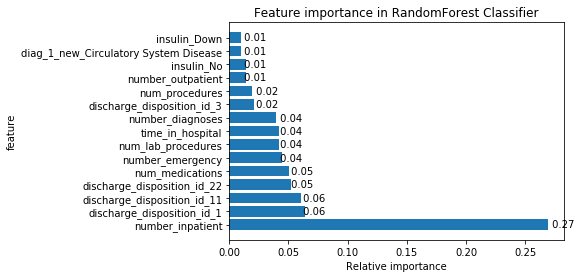

Accuracy 0.6405849540177898


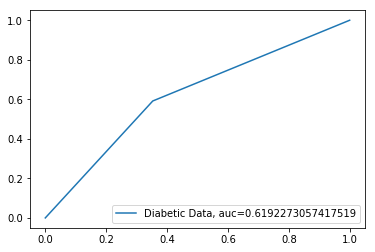

             precision    recall  f1-score   support

    class 0       0.92      0.65      0.76     17627
    class 1       0.18      0.59      0.27      2272

avg / total       0.84      0.64      0.71     19899



NameError: name 'y_pred' is not defined

In [13]:
diabetic = pd.read_csv('diabetic_data.csv',sep=",",header=0)

#Make the classes binary
diabetic.loc[diabetic['readmitted'] == 'NO','readmitted'] = 0
diabetic.loc[diabetic['readmitted'] == '>30','readmitted'] = 0
diabetic.loc[diabetic['readmitted'] == '<30','readmitted'] = 1

#replace question marks with python-recognizable NaN
diabetic = diabetic.replace('?', np.NaN)

#Drop first two variables
diabetic = diabetic.drop('encounter_id',axis=1)
diabetic = diabetic.drop('patient_nbr',axis=1)

#Drop Weight
diabetic = diabetic.drop('weight',axis=1)
#drop missing race rows
diabetic = diabetic.drop(diabetic[diabetic['race'].isna()].index)
##change some variables' data type to category:
diabetic[['admission_type_id','discharge_disposition_id','admission_source_id']]=diabetic[['admission_type_id','discharge_disposition_id','admission_source_id']].apply(lambda x: x.astype('category'))


##drop bad medicine:
bad_medicine=['metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone']
diabetic=diabetic.drop(bad_medicine,axis=1)

##drop payer code:
diabetic = diabetic.drop('payer_code',axis=1)

##Assign all diabetic codes that start with 'V' and 'E' to 1000
diabetic['diag_1'][diabetic['diag_1'].str.contains('V') == True] = 1000
diabetic['diag_1'][diabetic['diag_1'].str.contains('E') == True] = 1000

diabetic['diag_2'][diabetic['diag_2'].str.contains('V') == True] = 1000
diabetic['diag_2'][diabetic['diag_2'].str.contains('E') == True] = 1000

diabetic['diag_3'][diabetic['diag_3'].str.contains('V') == True] = 1000
diabetic['diag_3'][diabetic['diag_3'].str.contains('E') == True] = 1000

#Change diag_1, diag_2, diag_3 to numeric
diabetic['diag_1'] = pd.to_numeric(diabetic['diag_1'])
diabetic['diag_2'] = pd.to_numeric(diabetic['diag_2'])
diabetic['diag_3'] = pd.to_numeric(diabetic['diag_3'])


#Group diagnoses into buckets and call the new column ‘diag_1_new’
diabetic.loc[(diabetic['diag_1'] >= 0) & (diabetic['diag_1'] <= 139), 'diag_1_new'] = 'Infectious Diseases'
diabetic.loc[(diabetic['diag_1'] >= 140) & (diabetic['diag_1'] <= 239), 'diag_1_new'] = 'Neoplasms'
diabetic.loc[(diabetic['diag_1'] >= 240) & (diabetic['diag_1'] <= 279), 'diag_1_new'] = 'Endocrine Disorders'
diabetic.loc[(diabetic['diag_1'] >= 280) & (diabetic['diag_1'] <= 289), 'diag_1_new'] = 'Blood Diseases'
diabetic.loc[(diabetic['diag_1'] >= 290) & (diabetic['diag_1'] <= 319), 'diag_1_new'] = 'Mental Disorders'
diabetic.loc[(diabetic['diag_1'] >= 320) & (diabetic['diag_1'] <= 389), 'diag_1_new'] = 'Nervous System Disease'
diabetic.loc[(diabetic['diag_1'] >= 390) & (diabetic['diag_1'] <= 459), 'diag_1_new'] = 'Circulatory System Disease'
diabetic.loc[(diabetic['diag_1'] >= 460) & (diabetic['diag_1'] <= 519), 'diag_1_new'] = 'Respiratory System Disease'
diabetic.loc[(diabetic['diag_1'] >= 520) & (diabetic['diag_1'] <= 579), 'diag_1_new'] = 'Digestive System Disease'
diabetic.loc[(diabetic['diag_1'] >= 580) & (diabetic['diag_1'] <= 629), 'diag_1_new'] = 'Genitourinary Disease'
diabetic.loc[(diabetic['diag_1'] >= 630) & (diabetic['diag_1'] <= 679), 'diag_1_new'] = 'Pregnancy Complications'
diabetic.loc[(diabetic['diag_1'] >= 680) & (diabetic['diag_1'] <= 709), 'diag_1_new'] = 'Skin Disease'
diabetic.loc[(diabetic['diag_1'] >= 710) & (diabetic['diag_1'] <= 739), 'diag_1_new'] = 'Musculoskeleton Disease'
diabetic.loc[(diabetic['diag_1'] >= 740) & (diabetic['diag_1'] <= 759), 'diag_1_new'] = 'Congenital Anomalies'
diabetic.loc[(diabetic['diag_1'] >= 760) & (diabetic['diag_1'] <= 779), 'diag_1_new'] = 'Perinatal Conditions'
diabetic.loc[(diabetic['diag_1'] >= 780) & (diabetic['diag_1'] <= 799), 'diag_1_new'] = 'Ill-Defined Conditions'
diabetic.loc[(diabetic['diag_1'] >= 800) & (diabetic['diag_1'] <= 999), 'diag_1_new'] = 'Injury and Poisoning'
diabetic.loc[(diabetic['diag_1'] >= 1000),'diag_1_new'] = 'External Causes'

#Group diagnoses into buckets and call the new column ‘diag_2_new’   ( drop )
diabetic.loc[(diabetic['diag_2'] >= 0) & (diabetic['diag_2'] <= 139), 'diag_2_new'] = 'Infectious Diseases'
diabetic.loc[(diabetic['diag_2'] >= 140) & (diabetic['diag_2'] <= 239), 'diag_2_new'] = 'Neoplasms'
diabetic.loc[(diabetic['diag_2'] >= 240) & (diabetic['diag_2'] <= 279), 'diag_2_new'] = 'Endocrine Disorders'
diabetic.loc[(diabetic['diag_2'] >= 280) & (diabetic['diag_2'] <= 289), 'diag_2_new'] = 'Blood Diseases'
diabetic.loc[(diabetic['diag_2'] >= 290) & (diabetic['diag_2'] <= 319), 'diag_2_new'] = 'Mental Disorders'
diabetic.loc[(diabetic['diag_2'] >= 320) & (diabetic['diag_2'] <= 389), 'diag_2_new'] = 'Nervous System Disease'
diabetic.loc[(diabetic['diag_2'] >= 390) & (diabetic['diag_2'] <= 459), 'diag_2_new'] = 'Circulatory System Disease'
diabetic.loc[(diabetic['diag_2'] >= 460) & (diabetic['diag_2'] <= 519), 'diag_2_new'] = 'Respiratory System Disease'
diabetic.loc[(diabetic['diag_2'] >= 520) & (diabetic['diag_2'] <= 579), 'diag_2_new'] = 'Digestive System Disease'
diabetic.loc[(diabetic['diag_2'] >= 580) & (diabetic['diag_2'] <= 629), 'diag_2_new'] = 'Genitourinary Disease'
diabetic.loc[(diabetic['diag_2'] >= 630) & (diabetic['diag_2'] <= 679), 'diag_2_new'] = 'Pregnancy Complications'
diabetic.loc[(diabetic['diag_2'] >= 680) & (diabetic['diag_2'] <= 709), 'diag_2_new'] = 'Skin Disease'
diabetic.loc[(diabetic['diag_2'] >= 710) & (diabetic['diag_2'] <= 739), 'diag_2_new'] = 'Musculoskeleton Disease'
diabetic.loc[(diabetic['diag_2'] >= 740) & (diabetic['diag_2'] <= 759), 'diag_2_new'] = 'Congenital Anomalies'
diabetic.loc[(diabetic['diag_2'] >= 760) & (diabetic['diag_2'] <= 779), 'diag_2_new'] = 'Perinatal Conditions'
diabetic.loc[(diabetic['diag_2'] >= 780) & (diabetic['diag_2'] <= 799), 'diag_2_new'] = 'Ill-Defined Conditions'
diabetic.loc[(diabetic['diag_2'] >= 800) & (diabetic['diag_2'] <= 999), 'diag_2_new'] = 'Injury and Poisoning'
diabetic.loc[(diabetic['diag_2'] >= 1000),'diag_2_new'] = 'External Causes'

#Group diagnoses into buckets and call the new column ‘diag_3_new’
diabetic.loc[(diabetic['diag_3'] >= 0) & (diabetic['diag_3'] <= 139), 'diag_3_new'] = 'Infectious Diseases'
diabetic.loc[(diabetic['diag_3'] >= 140) & (diabetic['diag_3'] <= 239), 'diag_3_new'] = 'Neoplasms'
diabetic.loc[(diabetic['diag_3'] >= 240) & (diabetic['diag_3'] <= 279), 'diag_3_new'] = 'Endocrine Disorders'
diabetic.loc[(diabetic['diag_3'] >= 280) & (diabetic['diag_3'] <= 289), 'diag_3_new'] = 'Blood Diseases'
diabetic.loc[(diabetic['diag_3'] >= 290) & (diabetic['diag_3'] <= 319), 'diag_3_new'] = 'Mental Disorders'
diabetic.loc[(diabetic['diag_3'] >= 320) & (diabetic['diag_3'] <= 389), 'diag_3_new'] = 'Nervous System Disease'
diabetic.loc[(diabetic['diag_3'] >= 390) & (diabetic['diag_3'] <= 459), 'diag_3_new'] = 'Circulatory System Disease'
diabetic.loc[(diabetic['diag_3'] >= 460) & (diabetic['diag_3'] <= 519), 'diag_3_new'] = 'Respiratory System Disease'
diabetic.loc[(diabetic['diag_3'] >= 520) & (diabetic['diag_3'] <= 579), 'diag_3_new'] = 'Digestive System Disease'
diabetic.loc[(diabetic['diag_3'] >= 580) & (diabetic['diag_3'] <= 629), 'diag_3_new'] = 'Genitourinary Disease'
diabetic.loc[(diabetic['diag_3'] >= 630) & (diabetic['diag_3'] <= 679), 'diag_3_new'] = 'Pregnancy Complications'
diabetic.loc[(diabetic['diag_3'] >= 680) & (diabetic['diag_3'] <= 709), 'diag_3_new'] = 'Skin Disease'
diabetic.loc[(diabetic['diag_3'] >= 710) & (diabetic['diag_3'] <= 739), 'diag_3_new'] = 'Musculoskeleton Disease'
diabetic.loc[(diabetic['diag_3'] >= 740) & (diabetic['diag_3'] <= 759), 'diag_3_new'] = 'Congenital Anomalies'
diabetic.loc[(diabetic['diag_3'] >= 760) & (diabetic['diag_3'] <= 779), 'diag_3_new'] = 'Perinatal Conditions'
diabetic.loc[(diabetic['diag_3'] >= 780) & (diabetic['diag_3'] <= 799), 'diag_3_new'] = 'Ill-Defined Conditions'
diabetic.loc[(diabetic['diag_3'] >= 800) & (diabetic['diag_3'] <= 999), 'diag_3_new'] = 'Injury and Poisoning'
diabetic.loc[(diabetic['diag_3'] >= 1000),'diag_3_new'] = 'External Causes'

#Drop original diag columns
diabetic = diabetic.drop(['diag_1','diag_2','diag_3'],axis=1)

# drop 2 diag columns 
diabetic = diabetic.drop(['diag_2_new','diag_3_new'],axis=1)

# get dummies variabes 
diabetic=pd.get_dummies(diabetic)  
diabetic=diabetic.apply(pd.to_numeric, errors='coerce', axis=1)

diabetic_test = diabetic.sample(round(len(diabetic)*.2),random_state = 1)
diabetic_train_before = diabetic.drop(diabetic_test.index,axis=0)
diabetic_train = diabetic.drop(diabetic_test.index,axis=0)

diabetic_test_X=diabetic_test.drop('readmitted',axis=1)
diabetic_test_Y=diabetic_test['readmitted']

duplication1 = diabetic_train.loc[diabetic_train['readmitted'] == 1]
duplication2 = pd.concat([duplication1]*7)
diabetic_train = diabetic_train.append(duplication2)

diabetic_train_X = diabetic_train.drop('readmitted',axis=1)
diabetic_train_Y = diabetic_train['readmitted']

##testing set dummy varaible transformation:
diabetic_test_X=pd.get_dummies(diabetic_test_X)

missing_column=set(diabetic_test_X.columns).symmetric_difference(set(diabetic_train_X.columns))
missing_column=list(missing_column)
adding=pd.DataFrame(0, index=np.arange(len(diabetic_test_X)), columns=missing_column)
diabetic_test_X=diabetic_test_X.reset_index(drop=True)
diabetic_test_X=diabetic_test_X.join(adding, how='outer')
diabetic_test_X=diabetic_test_X[diabetic_train_X.columns]


############################### RANDOM FOREST ###############################

##Model building:  
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier(bootstrap=True, class_weight= 'balanced_subsample', criterion='entropy',
            max_depth=30, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=100, min_samples_split=2,
            min_weight_fraction_leaf=0.001, n_estimators=10000, n_jobs=2,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

##Using all the varaibles for model building: 

clf.fit(diabetic_train_X, diabetic_train_y)
predict_result=clf.predict(diabetic_test_X)

from sklearn.metrics import roc_auc_score
print("AUC - ROC : ", roc_auc_score(diabetic_test_y, predict_result))

##Feature importance visualization:

feature_importances = pd.DataFrame(clf.feature_importances_,
                                   index = diabetic_train_X.columns,
                                    columns=['importance']).sort_values('importance', 
                                                                    ascending=False)
feature_importances=feature_importances.reset_index()
feature_importances=feature_importances.iloc[0:15,:]
y_pos=np.arange(len(feature_importances))
plt.barh(y_pos, feature_importances.iloc[:,1].values)
plt.yticks(y_pos, feature_importances.iloc[:,0].values)
plt.title('Feature importance in RandomForest Classifier') 
plt.xlabel('Relative importance')
plt.ylabel('feature') 
for i, v in enumerate(round(feature_importances.iloc[:,1],2)):
    plt.text(v, i, " "+str(v), color='black', va='center')
plt.show()


##Overall Accuracy:
from sklearn.metrics import accuracy_score
accuracy_score(diabetic_test_y, predict_result)

##confusion matrix:
df_confusion = pd.crosstab(diabetic_test_y, predict_result)
df_confusion

from sklearn import metrics
print("Accuracy", metrics.accuracy_score(diabetic_test_y, predict_result))
from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(diabetic_test_y, predict_result)
auc = metrics.roc_auc_score(diabetic_test_y, predict_result)
plt.plot(fpr,tpr,label="Diabetic Data, auc="+str(auc))
plt.legend(loc=4)
plt.show()

from sklearn.metrics import classification_report

target_names = ['class 0', 'class 1']
print(classification_report(diabetic_test_y, predict_result, target_names=target_names))

# ################ combine prediction result of all 3 method into a list 
x=[y_pred,complete_predicted,predict_result]

# Final label for all methods using majority vote  
label=[]
    #find rows with k smallest distances
for i in range(0,len(y_pred)):
    sum_=(x[0][i]+x[1][i]+x[2][i])
        #classify point
    if (sum_>=2):
        label.append(1)
    else:
        label.append(0)


#df_confusion = pd.crosstab(diabetic_test_Y, label)
#Confusion matrix, Accuracy, sensitivity and specificity
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(diabetic_test_Y, label,labels=[1, 0])

print('Confusion Matrix : \n', cm1)

total1=sum(sum(cm1))
#####from confusion matrix calculate accuracy
accuracy1=(cm1[0,0]+cm1[1,1])/total1
print ('Accuracy : ', accuracy1)

sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print('Specificity : ', specificity1)

from sklearn.metrics import classification_report

target_names = ['class 0', 'class 1']
print(classification_report(diabetic_test_y,label, target_names=target_names))
